# Actividad evaluable del módulo 4: Clasificación mediante CNN del conjunto de datos FashionMNIST

Ahora que hemos aprendido a utilizar las capas convolucionales, vamos a enfrentarnos a un conjunto de datos nuevo y más complejo: [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist). Tiene un formato similar al conjunto de datos MNIST, pero contiene imágenes de diferentes prendas de ropa.

En esta actividad, deberá desarrollar un clasificador CNN que implemente **al menos 2 capas** convolucionales.

Más abajo, encontrará una plantilla con el código inicial. Le animamos a reutilizar código que haya escrito o visto en cuadernos anteriores.



In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Fíjese en que FashionMNIST también está integrado en PyTorch
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# Dividiremos el conjunto de entrenamiento en entrenamiento y validación

fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 14007632.30it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203657.90it/s]


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3845605.54it/s]


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21570706.29it/s]


Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [3]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


In [4]:
for input, label in dataloaders['train']:
  x = input
  y = label

In [5]:
print(input.shape)





torch.Size([100, 1, 28, 28])


## Visualización

Antes de seguir avanzando, nos interesa visualizar los puntos de datos del conjunto. De manera similar al conjunto de MNIST, en este tenemos 10 clases de objetos diferentes, marcadas con las siguientes etiquetas:

* 0 - Camiseta/top
* 1 - Pantalón
* 2 - Jersey
* 3 - Vestido
* 4 - Abrigo
* 5 - Sandalia
* 6 - Camisa
* 7 - Zapatilla
* 8 - Bolso
* 9 - Botín

Utilizando la función que aparece más abajo, podemos ver algunas de las imágenes de cada clase con las que trabajaremos. Para obtener más información sobre el conjunto de datos, acceda a este [enlace](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

In [6]:
# Trazar una ground truth sobre los datos y autocodificar
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # Solo queremos ver una clase determinada
            if (labels[i] != label):
                continue
            # Trazar la ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

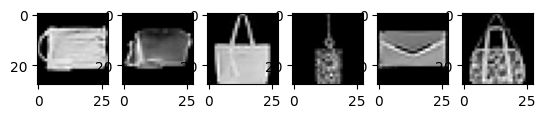

In [7]:
# Ver 6 bolsos
view_fashionmnist(8, 6)

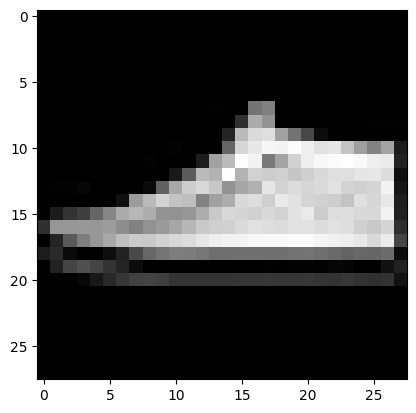

In [8]:
# Ver 1 zapatilla
view_fashionmnist(7, 1)

## Práctica

Aplique lo aprendido hasta ahora para desarrollar un clasificador CNN que implemente **al menos 2** capas convolucionales.

In [9]:
from torch.nn.modules.flatten import Flatten
# Pista: Cree una clase llamada CNNClassifier que implemente una función "forward"

class CNNClassifier(nn.Module):
  def __init__(self):
    super(CNNClassifier, self).__init__()

    self.pipeline = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=1, stride=1), #Straide 1 es decir avance un pexil.
        nn.Conv2d(in_channels=12, out_channels=9, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=9, out_channels=6, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), #Dividimos en dos nuestra imgane eran de 28x28 nos quedaran de 14*14 y 9 canales.
        nn.Flatten(),
        nn.Linear(in_features=6*14*14, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(32,10) #damos como salida las 10 categorias que tenemos de prendas
    )

  def forward(self, x):
    return self.pipeline(x)


Implementamos rede neuronal con dropout

In [10]:
class CNNClassifierDropout(nn.Module):
  def __init__(self,dropout):
    super(CNNClassifierDropout, self).__init__()
    self.dropout = nn.Dropout(dropout)

    self.pipeline = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=1, stride=1), #Straide 1 es decir avance un pexil.
        nn.Conv2d(in_channels=12, out_channels=9, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=9, out_channels=6, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), #Dividimos en dos nuestra imgane eran de 28x28 nos quedaran de 14*14 y 9 canales.
        nn.Flatten(),
        nn.Linear(in_features=6*14*14, out_features=64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32,10) #damos como salida las 10 categorias que tenemos de prendas
    )

  def forward(self, x):
    return self.pipeline(x)


In [11]:
learning_rate1 = 0.001
num_epochs1 = 30
model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(9, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1176, out_features=64, bias=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=32, bias=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [12]:
from torch.ao.nn.quantized.modules import dropout
learning_rate2 = 0.001
num_epochs2 = 30
dropout = .25
model2 = CNNClassifierDropout(dropout).to(device)
print(model2)

CNNClassifierDropout(
  (dropout): Dropout(p=0.25, inplace=False)
  (pipeline): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(9, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1176, out_features=64, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.25, inplace=False)
    (14): Linear(in_features=64, out_features=32, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.25, inplace=False)
    (17): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [13]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_acc = 0.0
    best_epoch = 0

     # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']

    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                # No hace falta alisar los inputs
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [14]:
# Pérdida y optimizador para el modelo sin dropout
criterion1 = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate1)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer1, gamma=0.95)


# Entrenamos el modelo y además guardamos los resultados del entrenamiento para poder visualizarlos
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion1, optimizer1, scheduler1, num_epochs=num_epochs1)


Epoch 1/30
----------
train Loss: 0.6510 Acc: 0.7607
val   Loss: 0.4114 Acc: 0.8496
test  Loss: 0.4288 Acc: 0.8378

Epoch 2/30
----------
train Loss: 0.3511 Acc: 0.8724
val   Loss: 0.3334 Acc: 0.8797
test  Loss: 0.3485 Acc: 0.8726

Epoch 3/30
----------
train Loss: 0.2975 Acc: 0.8916
val   Loss: 0.3036 Acc: 0.8897
test  Loss: 0.3178 Acc: 0.8856

Epoch 4/30
----------
train Loss: 0.2639 Acc: 0.9039
val   Loss: 0.3049 Acc: 0.8900
test  Loss: 0.3174 Acc: 0.8860

Epoch 5/30
----------
train Loss: 0.2388 Acc: 0.9120
val   Loss: 0.2805 Acc: 0.9001
test  Loss: 0.2932 Acc: 0.8939

Epoch 6/30
----------
train Loss: 0.2169 Acc: 0.9211
val   Loss: 0.2756 Acc: 0.9029
test  Loss: 0.2888 Acc: 0.8961

Epoch 7/30
----------
train Loss: 0.1995 Acc: 0.9272
val   Loss: 0.2739 Acc: 0.9055
test  Loss: 0.2866 Acc: 0.8994

Epoch 8/30
----------
train Loss: 0.1840 Acc: 0.9320
val   Loss: 0.2756 Acc: 0.9081
test  Loss: 0.2871 Acc: 0.9013

Epoch 9/30
----------
train Loss: 0.1697 Acc: 0.9376
val   Loss: 0.2792

In [15]:

# Pérdida y optimizador para el modelo2 con dropout
criterion2 = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer2, gamma=0.95)


# Entrenamos el modelo y además guardamos los resultados del entrenamiento para poder visualizarlos
model2, training_curves2 = train_classification_model(model2, dataloaders, dataset_sizes,
                                     criterion2, optimizer2, scheduler2, num_epochs=num_epochs2)


Epoch 1/30
----------
train Loss: 0.8123 Acc: 0.7064
val   Loss: 0.4354 Acc: 0.8435
test  Loss: 0.4475 Acc: 0.8353

Epoch 2/30
----------
train Loss: 0.4808 Acc: 0.8315
val   Loss: 0.3688 Acc: 0.8695
test  Loss: 0.3833 Acc: 0.8612

Epoch 3/30
----------
train Loss: 0.4145 Acc: 0.8569
val   Loss: 0.3320 Acc: 0.8817
test  Loss: 0.3476 Acc: 0.8739

Epoch 4/30
----------
train Loss: 0.3743 Acc: 0.8690
val   Loss: 0.3122 Acc: 0.8889
test  Loss: 0.3289 Acc: 0.8856

Epoch 5/30
----------
train Loss: 0.3462 Acc: 0.8792
val   Loss: 0.2911 Acc: 0.8973
test  Loss: 0.3109 Acc: 0.8916

Epoch 6/30
----------
train Loss: 0.3227 Acc: 0.8870
val   Loss: 0.2823 Acc: 0.9002
test  Loss: 0.2989 Acc: 0.8947

Epoch 7/30
----------
train Loss: 0.3063 Acc: 0.8930
val   Loss: 0.2729 Acc: 0.9043
test  Loss: 0.2922 Acc: 0.8963

Epoch 8/30
----------
train Loss: 0.2878 Acc: 0.9004
val   Loss: 0.2680 Acc: 0.9052
test  Loss: 0.2899 Acc: 0.8959

Epoch 9/30
----------
train Loss: 0.2780 Acc: 0.9014
val   Loss: 0.2658

### Visualizar las curvas de entrenamiento y los resultados

In [16]:
# Estas funciones de utilidad sirven para trazar los resultados
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en modo evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


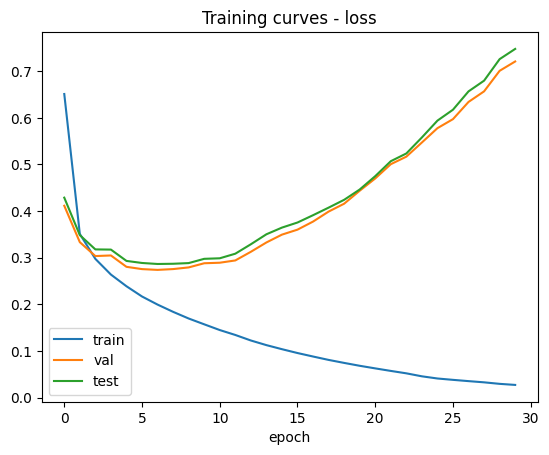

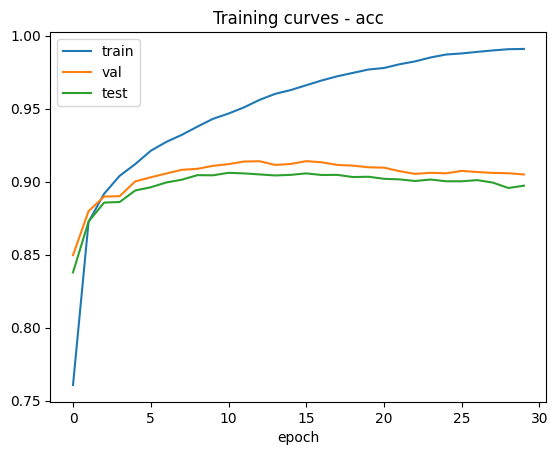

In [17]:
# Curves del modelo sin dropout
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

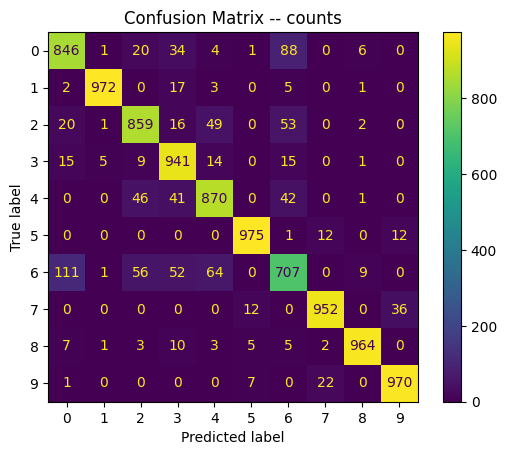

In [18]:
# modeo uno sin el dropout
res = plot_cm(model, device, dataloaders, phase='test')

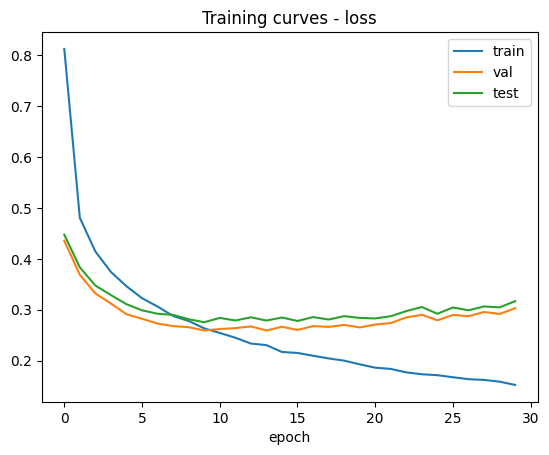

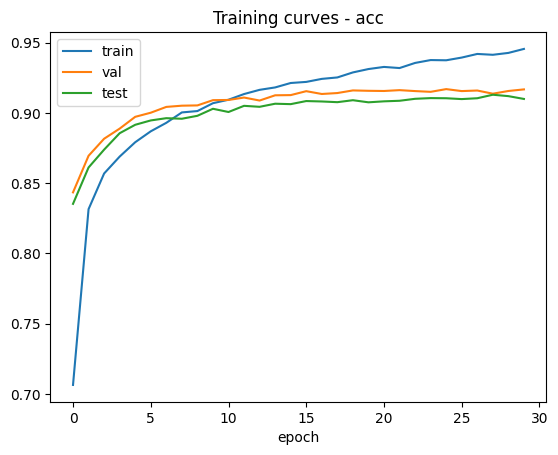

In [19]:
# curves del modelo 2 con droout
plot_training_curves(training_curves2, phases=['train', 'val', 'test'])

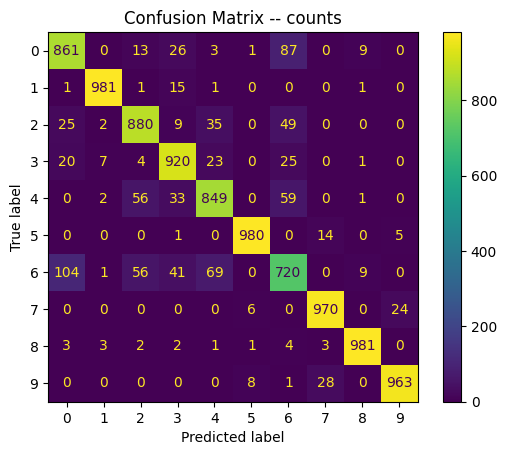

In [20]:
# modeo dos con el dropout
res = plot_cm(model2, device, dataloaders, phase='test')

## Conclusiones

Ahora que hemos implementado la red, debemos examinar los resultados.

¿Qué clase de objeto se clasifica incorrectamente más a menudo?¿Qué etiqueta incorrecta se le suele asignar?

Intente también volver a entrenar su red incluyendo el *dropout*. ¿Mejora el rendimiento o hay algún cambio reseñable en la capacidad de generalización del modelo?¿El objeto que más a menudo se clasifica erróneamente sigue siendo el mismo que antes de introducir el *dropout*?

Conclusiones

Con nuestro modelo sin dropout, podemos observar que la etiqueta con mas frecuencia de error es 6 ya que predijo erroneamoente la mayoria de las observaciones que es un 0, de igual manera podemos observar en las gráficas que contamos con un sobreajuste.

Con el modelo con Dropout.

en las gráficas podemos observar que hemos eliminado significativamente el sobreajuste, aunque vemos que la etiqueta con más error sigue siendo la misma, aunque vajo el error en esa etiqueta.

Conclusión
  Para mejorar nuestro modelo aún más deberiamos usar data augmentation y tener mejores aciertos y agregar más capas convulucionales.
  





  